In [379]:
import pandas as pd
import datetime
from handyspark import *
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, BooleanType, IntegerType
from pyspark.sql.column import Column, _to_java_column, _to_seq
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def is_digit(value):
    if value:
        return value.isdigit()
    else:
        return False

is_digit_udf = f.udf(is_digit, BooleanType())

# Writes the average age per country into a csv file which can later be imported into google maps
def write_avg_age_per_country(corona, file_name: str):
    data = corona.select(['Country', 'age', 'latitude', 'longitude'])
    data = data.dropna(how='any')
    avg_age = data.groupBy('Country').agg({'age': 'avg', 'latitude': 'avg', 'longitude': 'avg'})
    avg_age.repartition(1).write.csv('{}{}'.format(root_path, file_name), header = 'true', mode="overwrite")
    
def get_recent_and_middle_country_data(country_data):
    country_date_window = Window.partitionBy(country_data.Country).orderBy(country_data.Date.desc())
    ranked_date_in_country = country_data.withColumn("dense_rank",f.dense_rank().over(country_date_window))
    recent = ranked_date_in_country.filter(f.col("dense_rank")==1)
    middle_rank = ranked_date_in_country.groupBy('Country').agg({'dense_rank': 'mean'})
    middle_rank = middle_rank.withColumn('rounded', middle_rank['avg(dense_rank)'].cast("int"))
    middle_date = ranked_date_in_country.join(middle_rank, middle_rank.rounded == ranked_date_in_country.dense_rank)
    middle_date = middle_date.drop('rounded')
    middle_date = middle_date.drop('avg(dense_rank)')
    return recent.drop('dense_rank'), middle_date
    
def boxplot_age_vs_country(corona):
    valid_corona_countries = corona.filter('country != "NaN"')
    valid_corona_ages = valid_corona_countries.filter(is_digit_udf(corona.age))
    age_as_number = valid_corona_ages.withColumn("age", valid_corona_ages.age.cast('double'))
    handy_age = age_as_number.toHandy()
    # https://github.com/dvgodoy/handyspark/issues/20
    fig, axs = handy_age.stratify(['country']).cols['age'].boxplot()
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, horizontalalignment='right')
    return fig, axs

# Make sure country_dataframe is small enough to collect since this function uses pandas
def scatterplot_countries_local(country_dataframe, x, y, ax=None):
    x_and_y_per_country = country_dataframe.select(['Country', x, y])
    x_and_y_per_country = x_and_y_per_country.withColumn(x, x_and_y_per_country[x].cast("float"))
    x_and_y_per_country = x_and_y_per_country.withColumn(y, x_and_y_per_country[y].cast("float"))
    x_and_y_per_country = x_and_y_per_country.filter('isNaN("{}") == False and isNaN("{}") == False'.format(x, y))
    pd_x_and_y_per_country = x_and_y_per_country.toPandas()
    plot = pd_x_and_y_per_country.plot.scatter(x, y, ax=ax)
    for i, txt in enumerate(pd_x_and_y_per_country.Country):
        plot.annotate(txt, (pd_x_and_y_per_country[x].iat[i], pd_x_and_y_per_country[y].iat[i]))

def densityplot_countermeasures_local(countermeasures, column):
    collected_count = countermeasures.groupBy(column).count().collect()
    # After grouping and counting we can collect it and use it in panda since it should be small enough
    data = {}
    for entry in collected_count:
        data[float(entry[column])] = int(entry['count'])
    frame = pd.DataFrame(data, index=['Density']).transpose()
    ax = frame.plot.density(legend=False)
    ax.set_xlabel(column)


root_path='file:///mnt/notebooks/'
def load_csv_file(relative_path: str, has_header: bool=True, inferSchema: bool=False):
    return spark.read.csv('{}{}'.format(root_path, relative_path), inferSchema=inferSchema, header=has_header)
    

### גרף המתאר התפלגות גילאים בכל מדינה
- אנו גם מייצרים קובץ שנטען אותו בגוגל מפות המראה את הגיל הממוצע בכל מדינה

כל עמודה מתארת התפלגות נורמלית עבור הגילאים של החולים באותה מדינה

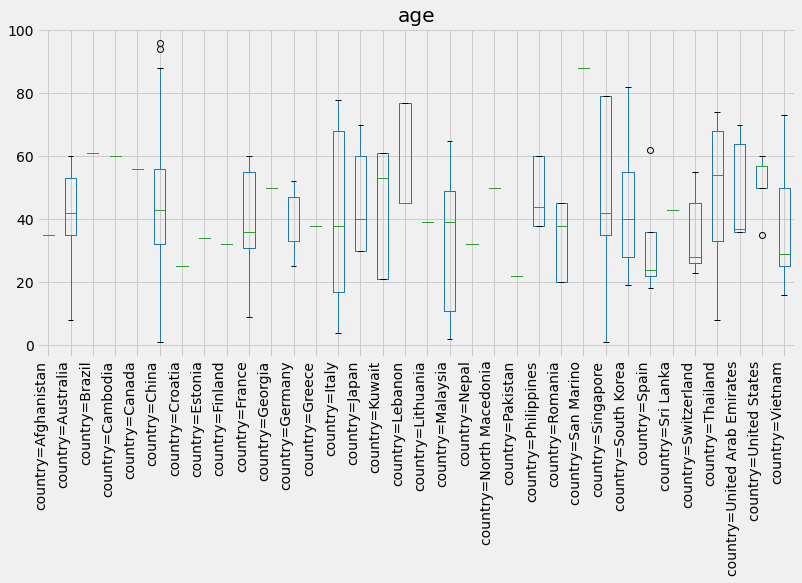

In [380]:
corona = load_csv_file('corona/kaggle/COVID19_open_line_list.csv')
fig, axs = boxplot_age_vs_country(corona)
fig.set_size_inches(18,6)
write_avg_age_per_country(corona, 'avg_age.csv')

In [419]:
from IPython.display import IFrame
IFrame('https://www.google.com/maps/d/u/1/embed?mid=1gE_2hFbAZ1LCxmxMnq5zyiOwA3tTa-1E', width=800, height=480)

### ?מהי פונקצית צפיפות בהקשר של סגירת בתי ספר
- אפשר לחשוב על הפונקציה שהגרף מתאר כגל
- כלומר הוא בא לענות על השאלה האם עוד מדינות הולכות לסגור בתי ספר

### :צפיפות של סגירת בתי ספר ע"י מדינות
- בגרף הראשון אנו מסתכלים על נקודת האמצע מבחינת תאריכים
- בגרף השני אנו מסתכלים על היום הכי עדכני עבור כל המדינות

ניתן לראות כי לאורך זמן יותר מדינות סגרו את בתי הספר שלהן

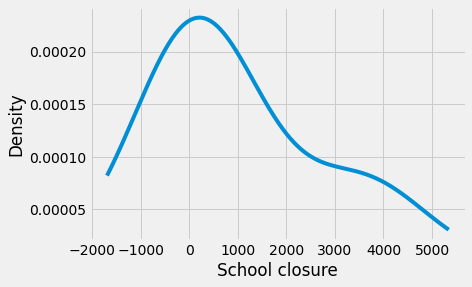

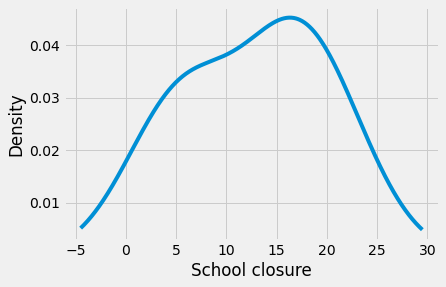

In [382]:
countermeasures = load_csv_file('corona/countermeasures/countermeasures_db_johnshopkins.csv')
countermeasures = countermeasures.withColumn('Death Ratio', countermeasures['Deaths'] / countermeasures['Confirmed Cases'])
countermeasures = countermeasures.withColumn('Testing Ratio', countermeasures['Testing'] / countermeasures['Confirmed Cases'])
recent, middle = get_recent_and_middle_country_data(countermeasures)
densityplot_countermeasures(middle, 'School closure')
densityplot_countermeasures(recent, 'School closure')

### הגדרות
* נגדיר את יחס המוות להיות כמות המתים חלקי כמות החולים
* נגדיר את יחס הבדיקות להיות כמות הבדיקות חלקי כמות החולים
* מדדי האושר של מדינה נקבעים ע"י דירוג של אזרחי המדינה
  * המדדים כוללים בין השאר צפייה לחיים ארוכים ונדיבות

### ניצור גרפים המשווים בין יחס המוות לפרמטרים הבאים
* יחס הבדיקות
* נדיבות
* צפי לחיים ארוכים

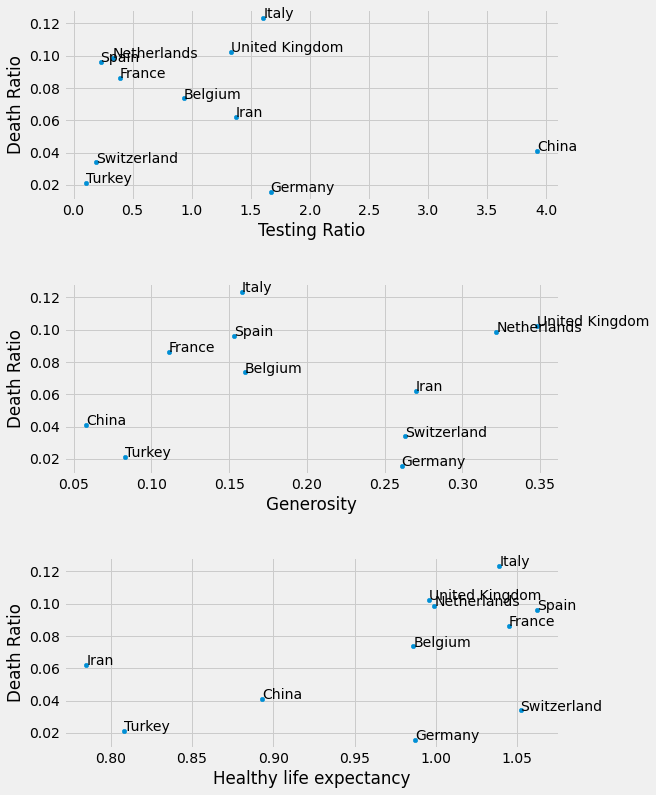

In [383]:
latest_world_happiness = load_csv_file('world_happiness/2019.csv')
recent_counter_and_happiness = most_recent_countermeasure_data.join(latest_world_happiness, most_recent_countermeasure_data.Country == latest_world_happiness['Country or region'])
recent_counter_and_happiness = recent_counter_and_happiness.withColumn("Date", f.to_date(f.unix_timestamp(most_recent_countermeasure_data.Date, "yyyy-MM-dd").cast("timestamp")))
large_death_count = recent_counter_and_happiness.filter('Deaths > 500')
fig, axes = plt.subplots(3, 1, figsize=(10,12))
scatterplot_countries_local(large_death_count, 'Testing Ratio', 'Death Ratio', axes[0])  
scatterplot_countries_local(large_death_count, 'Generosity', 'Death Ratio', axes[1])
scatterplot_countries_local(large_death_count, 'Healthy life expectancy', 'Death Ratio', axes[2])
fig.tight_layout(pad=3.0)

In [384]:
cases = load_csv_file('corona/misc/COVID-19_cases.csv', inferSchema=True)
cases.printSchema()
corona_daily = cases.select('dateRep','countriesAndTerritories', 'cases', 'deaths')
#df2.printSchema()
corona_daily = corona_daily.groupBy('dateRep').agg({'cases': 'sum', 'deaths': 'sum'})
corona_daily = corona_daily.withColumn("dateRep", f.to_timestamp(f.unix_timestamp(corona_daily.dateRep, "dd/MM/yyyy").cast("timestamp")))
corona_daily = corona_daily.withColumnRenamed("dateRep", "Date")
corona_daily.show()

root
 |-- dateRep: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- countriesAndTerritories: string (nullable = true)
 |-- geoId: string (nullable = true)
 |-- countryterritoryCode: string (nullable = true)
 |-- popData2018: integer (nullable = true)

+-------------------+----------+-----------+
|               Date|sum(cases)|sum(deaths)|
+-------------------+----------+-----------+
|2020-03-28 00:00:00|     63937|       3318|
|2020-01-19 00:00:00|       136|          1|
|2020-02-25 00:00:00|       793|         79|
|2020-01-04 00:00:00|         0|          0|
|2020-03-07 00:00:00|      3961|        103|
|2020-01-15 00:00:00|         1|          1|
|2020-02-13 00:00:00|     15151|        255|
|2020-01-18 00:00:00|        17|          0|
|2020-03-01 00:00:00|      1821|         58|
|2020-01-06 00:00:00|         0|       

In [385]:
country_cases_and_death = cases.select('countriesAndTerritories', 'cases', 'deaths')
country_cases_and_death = country_cases_and_death.groupBy('countriesAndTerritories').agg({'cases': 'sum', 'deaths': 'sum'})
country_cases_and_death.printSchema()
df1 = country_cases_and_death.orderBy(country_cases_and_death['sum(cases)'].desc()).show()
country_cases_and_death.printSchema()

root
 |-- countriesAndTerritories: string (nullable = true)
 |-- sum(cases): long (nullable = true)
 |-- sum(deaths): long (nullable = true)

+-----------------------+----------+-----------+
|countriesAndTerritories|sum(cases)|sum(deaths)|
+-----------------------+----------+-----------+
|   United_States_of_...|    368196|      10989|
|                  Spain|    135032|      13055|
|                  Italy|    132547|      16525|
|                Germany|     99225|       1607|
|                  China|     82698|       3335|
|                 France|     74390|       8911|
|                   Iran|     60500|       3739|
|         United_Kingdom|     51608|       5373|
|                 Turkey|     30217|        649|
|            Switzerland|     21574|        584|
|                Belgium|     20814|       1632|
|            Netherlands|     18803|       1867|
|                 Canada|     16653|        323|
|                Austria|     12297|        220|
|                 Brazil|

In [386]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
AAL_df = pd.read_csv('stocks/AAL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

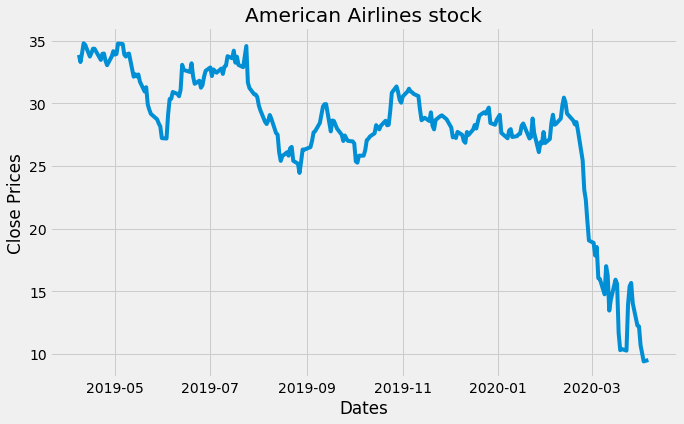

In [387]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(AAL_df['Close'])
plt.title('American Airlines stock')
plt.show()

המשבר שמטביע את תעשיית התעופה העולמית מחריף. 
אמריקן איירליינס הודיעו על ירידה צפויה בהכנסות, קיצוצים חדים בטיסותיהן ומהלכי חירום נוספים. זאת, במטרה לצמצם את נזקי נגיף הקורונה שמדלל באופן דרסטי את תנועתה נוסעים העולמית.
נכון ל־2019, אמריקן איירליינס היא חברת התעופה הגדולה בעולם עם צי של 956 מטוסים.

### Cases & Deaths by country

    countriesAndTerritories  sum(cases)  sum(deaths)
0               Afghanistan         337            7
1                   Albania         377           22
2                   Andorra         526           21
3                   Algeria        1423          173
4                    Angola          16            2
..                      ...         ...          ...
199              Uzbekistan         397            2
200               Venezuela         159            5
201                 Vietnam         245            0
202                  Zambia          39            1
203                Zimbabwe           9            1

[204 rows x 3 columns]
countriesAndTerritories    object
sum(cases)                  int64
sum(deaths)                 int64
dtype: object
      countriesAndTerritories  sum(cases)  sum(deaths)
74                    Germany       99225         1607
97                     Israel        8904           57
98                      Italy      132547        16525
176 

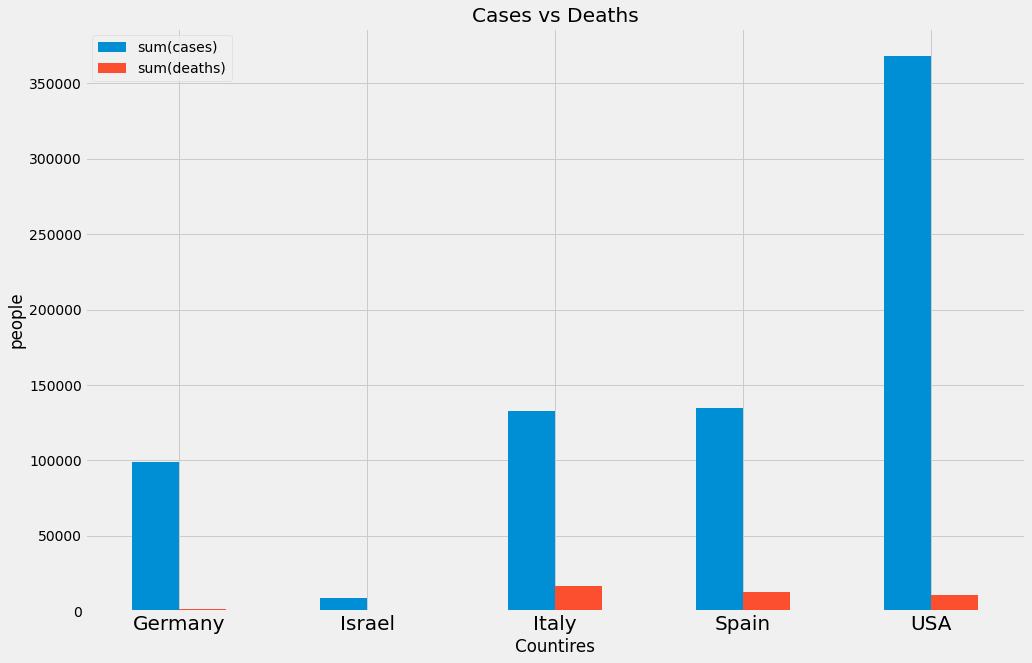

In [388]:
import numpy as np
index = ('Germany', 'Israel', 'Italy', 'Spain', 'USA')

df2= pd.read_csv('corona/misc/coronaByCountry.csv')
print(df2)
print(df2.dtypes)
i= df2[df2['countriesAndTerritories'].str.contains("United_States_of_America") | df2['countriesAndTerritories'].str.contains("Italy") | df2['countriesAndTerritories'].str.contains("Israel") | df2['countriesAndTerritories'].str.contains("Spain") | df2['countriesAndTerritories'].str.contains("Germany")]
print(i)


ax = i[['sum(cases)','sum(deaths)']].plot(kind='bar', title ="Cases vs Deaths", figsize=(15, 10), legend=True, fontsize=14)
y_pos= np.arange(len(index))
ax.set_xlabel('Countires')
ax.set_ylabel('people')

ax.set_xticklabels(index, rotation=0, fontsize=20)
plt.show()

In [389]:
df3 = load_csv_file('stocks/wti_daily_csv.csv', inferSchema=True)
df3 = df3.filter(df3["Date"].contains("2020"))
df3.show()
#df3.write.option("header", "true").csv('wti_daily_2020.csv')

+-------------------+-----+
|               Date|Price|
+-------------------+-----+
|2020-01-02 00:00:00|61.17|
|2020-01-03 00:00:00| 63.0|
|2020-01-06 00:00:00|63.27|
|2020-01-07 00:00:00| 62.7|
|2020-01-08 00:00:00|59.65|
|2020-01-09 00:00:00|59.56|
|2020-01-10 00:00:00|59.02|
|2020-01-13 00:00:00|58.17|
|2020-01-14 00:00:00|58.34|
|2020-01-15 00:00:00|57.86|
|2020-01-16 00:00:00|58.52|
|2020-01-17 00:00:00|58.55|
|2020-01-21 00:00:00|58.25|
|2020-01-22 00:00:00|56.76|
|2020-01-23 00:00:00|55.51|
|2020-01-24 00:00:00|54.09|
|2020-01-27 00:00:00|53.09|
|2020-01-28 00:00:00|53.33|
|2020-01-29 00:00:00|53.29|
|2020-01-30 00:00:00|52.19|
+-------------------+-----+
only showing top 20 rows



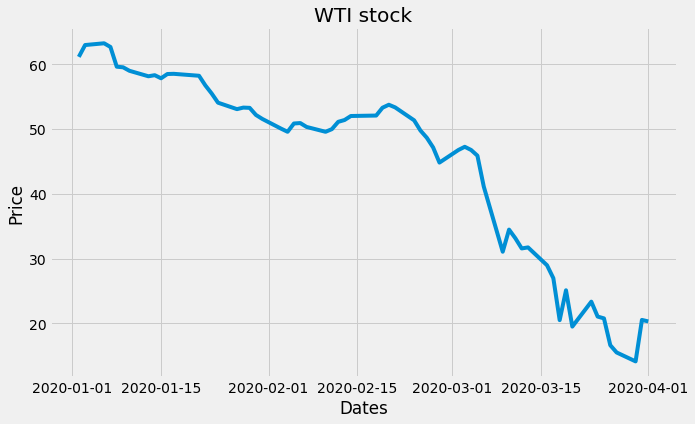

In [390]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
wti = pd.read_csv('stocks/wti_daily_2020.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(wti['Price'])
plt.title('WTI stock')
plt.show()

### Compare changes WTI & AAL stock

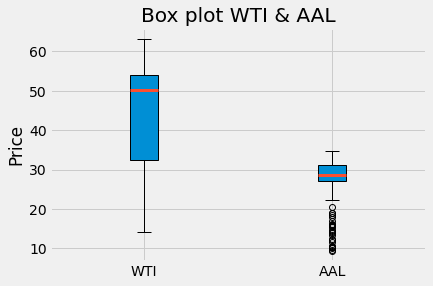

In [391]:
import matplotlib
matplotlib.axes.Axes.boxplot
matplotlib.pyplot.boxplot


data1 = [wti['Price'], AAL_df['Close']]
labels= ['WTI', 'AAL']
fig7, ax7 = plt.subplots()
ax7.set_title('Box plot WTI & AAL')
ax7.boxplot(data1, labels=labels, patch_artist=True,  medianprops={'linewidth':3})
plt.ylabel('Price')
plt.show()


##### עבור הנפט אנו רואים שרוב הערכים נמצאים 30 ל55 כאשר הממוצע לאורך זמן הינו 50
##### כאשר יש נפילה דרמטית עד לערכים מינימליים של 15
##### עבור מחיר המנייה של חברת התעופה אנו רואים שהממוצע לאורך הזמן היה 30 ורוב הזמן זה נשאר כך
##### אך בעקבות משבר הקורונה נהיו ערכים מינימליים שרחוקים  מאוד מהטווח- הנקודות


In [392]:
# join dataframe by date

all1= load_csv_file('stocks/AAL.csv', inferSchema=True)
wti1= load_csv_file('stocks/wti_daily_2020.csv', inferSchema=True)
inner_join = all1.join(wti1, ["Date"])

inner_join.show()

+-------------------+---------+---------+---------+---------+---------+--------+-----+
|               Date|     Open|     High|      Low|    Close|Adj Close|  Volume|Price|
+-------------------+---------+---------+---------+---------+---------+--------+-----+
|2020-01-02 00:00:00|    28.98|29.299999|    28.65|    29.09|28.982893| 6451100|61.17|
|2020-01-03 00:00:00|    28.27|28.290001|    27.34|    27.65|27.548195|14008900| 63.0|
|2020-01-06 00:00:00|27.190001|    27.49|    27.08|    27.32| 27.21941| 6105800|63.27|
|2020-01-07 00:00:00|27.559999|    27.68|27.059999|27.219999|27.119778| 6105900| 62.7|
|2020-01-08 00:00:00|     27.1|    28.09|    27.07|    27.84|27.737495|10496800|59.65|
|2020-01-09 00:00:00|    28.09|    28.23|27.709999|27.950001|27.847092| 6898900|59.56|
|2020-01-10 00:00:00|27.959999|    27.99|    27.25|    27.32| 27.21941| 8106800|59.02|
|2020-01-13 00:00:00|    27.32|27.530001|    27.16|27.389999|27.289152| 5874400|58.17|
|2020-01-14 00:00:00|    27.91|     28.4|  

In [393]:
# Save results

#inner_join.write.option("header", "true").csv('join_wti_AAL.csv')

Text(0, 0.5, 'ALL stock')

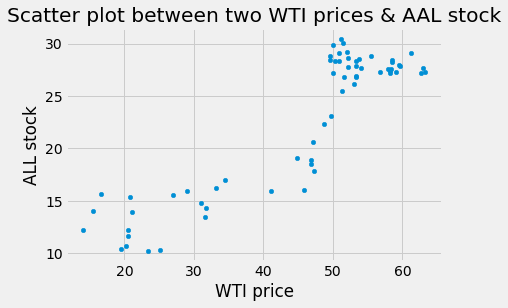

In [394]:
join_wti_AAL = pd.read_csv('stocks/join_wti_AAL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

a =join_wti_AAL.plot.scatter(x='Price', y='Close', title= "Scatter plot between two WTI prices & AAL stock");
a.set_xlabel('WTI price')
a.set_ylabel('ALL stock')

#### בדיקה לגבי אופן השינוי של המחירים בעקבות משבר הקורונה
נראה שהייתה יציבות לפני שהקורונה החלה, הגוש הימיני העליון

עם הזמן בחודשים האחרונים יש קריסה כללית בביקוש לנפט- 
רוב הטיסות בעולם מושבתות ולכן גם אין רווח מנסיגת מחיר הנפט

In [395]:
from pyspark.sql.functions import corr

In [396]:
join_wti_AAL1 = load_csv_file('stocks/join_wti_AAL.csv', inferSchema=True)

join_wti_AAL1.printSchema()
join_wti_AAL1.select(corr('Price', 'Close')).show()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Price: double (nullable = true)

+------------------+
|corr(Price, Close)|
+------------------+
|0.9017850410477426|
+------------------+



 #### יש קורולוציה של 90% בין מחיר הנפט למניית אמריקן איירליינס

In [397]:
# join dataframe by date
corona_daily.printSchema()
join_wti_AAL1.printSchema()
inner_join1 = join_wti_AAL1.join(corona_daily, corona_daily.Date == join_wti_AAL1.Date)
#inner_join1= inner_join1.orderBy('Date', ascending=False)
inner_join1.printSchema()
inner_join1.count()

root
 |-- Date: timestamp (nullable = true)
 |-- sum(cases): long (nullable = true)
 |-- sum(deaths): long (nullable = true)

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Price: double (nullable = true)

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- sum(cases): long (nullable = true)
 |-- sum(deaths): long (nullable = true)



63

### A negative correlation between WTI price to cases or deaths of Corona virus

In [398]:
inner_join1.select(corr('sum(cases)', 'Price')).show()

+-----------------------+
|corr(sum(cases), Price)|
+-----------------------+
|    -0.8124530272977015|
+-----------------------+



In [399]:
inner_join1.select(corr('sum(deaths)', 'Price')).show()

+------------------------+
|corr(sum(deaths), Price)|
+------------------------+
|     -0.7789574976004693|
+------------------------+



### Linear Regression
Runnig linear regression that shows prediction on oil prices by the data of cases and deaths of Corona virus and  American Airlines stock.

In [400]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [401]:
inner_join1.head(1)[0]

Row(Date=datetime.datetime(2020, 2, 25, 0, 0), Open=25.620001, High=25.75, Low=23.049999, Close=23.120001, Adj Close=23.120001, Volume=22296900, Price=49.78, Date=datetime.datetime(2020, 2, 25, 0, 0), sum(cases)=793, sum(deaths)=79)

In [402]:
assembler = VectorAssembler(inputCols=['Close','sum(cases)', 'sum(deaths)'],
                           outputCol='features')
output= assembler.transform(inner_join1)

In [403]:
# new column 'features' - Vector of the input values
output.head(1)

[Row(Date=datetime.datetime(2020, 2, 25, 0, 0), Open=25.620001, High=25.75, Low=23.049999, Close=23.120001, Adj Close=23.120001, Volume=22296900, Price=49.78, Date=datetime.datetime(2020, 2, 25, 0, 0), sum(cases)=793, sum(deaths)=79, features=DenseVector([23.12, 793.0, 79.0]))]

In [404]:
final_data = output.select('features', 'Price')
#final_data.show()

In [405]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [406]:
train_data.describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|                41|
|   mean| 45.65878048780487|
| stddev|13.469431909906586|
|    min|             15.48|
|    max|             63.27|
+-------+------------------+



In [407]:
test_data.describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|                22|
|   mean| 43.59318181818182|
| stddev|16.081575789397316|
|    min|              14.1|
|    max|              63.0|
+-------+------------------+



In [408]:
lr = LinearRegression(labelCol= 'Price')

In [409]:
lr_model = lr.fit(train_data)

In [410]:
test_results = lr_model.evaluate(test_data)

In [411]:
test_results.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| 0.7539774472626561|
|  2.872232525306586|
| 2.4020020205179264|
|  7.661469413858914|
|-0.5285976856139722|
| 4.0844251333236485|
| -2.722194452239762|
| 3.5112955945987423|
|-1.9606838278053118|
|  7.938085298521173|
|  -3.73921054772962|
| -5.496730866049049|
| -8.211848306952099|
|  4.170499216087009|
| 2.0544426734055037|
| -2.696723897085448|
| -2.337914487259752|
|   6.08725020798245|
| 0.4773883553942255|
|  3.443766318047196|
+-------------------+
only showing top 20 rows



In [412]:
test_results.rootMeanSquaredError

4.368290850970048

In [413]:
test_results.r2

0.9227018185854577

In [414]:
final_data.describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|                63|
|   mean| 44.93746031746033|
| stddev|14.339810810855973|
|    min|              14.1|
|    max|             63.27|
+-------+------------------+



In [415]:
unlabled_data = test_data.select('features')

In [416]:
unlabled_data.show()

+--------------------+
|            features|
+--------------------+
|[23.120001,793.0,...|
|     [27.58,1.0,1.0]|
|[30.09,15151.0,25...|
|[10.69,73512.0,46...|
|[12.25,58487.0,31...|
| [27.950001,0.0,0.0]|
|[15.66,51204.0,24...|
|[10.25,33016.0,16...|
|[27.719999,1756.0...|
|    [27.65,17.0,0.0]|
|  [29.1,3907.0,66.0]|
|[16.26,4378.0,269.0]|
|[11.65,14740.0,78...|
|     [29.09,0.0,0.0]|
|  [20.6,1106.0,38.0]|
| [27.16,2818.0,57.0]|
|[28.33,1864.0,139.0]|
| [17.85,1797.0,72.0]|
|[26.110001,797.0,...|
| [27.389999,1.0,0.0]|
+--------------------+
only showing top 20 rows



In [417]:
predictions = lr_model.transform(unlabled_data)

In [418]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[23.120001,793.0,...|49.026022552737345|
|     [27.58,1.0,1.0]| 54.98776747469341|
|[30.09,15151.0,25...| 49.00799797948207|
|[10.69,73512.0,46...|12.618530586141087|
|[12.25,58487.0,31...|14.628597685613972|
| [27.950001,0.0,0.0]|55.475574866676354|
|[15.66,51204.0,24...|19.322194452239764|
|[10.25,33016.0,16...|19.818704405401256|
|[27.719999,1756.0...| 54.15068382780531|
|    [27.65,17.0,0.0]| 55.06191470147883|
|  [29.1,3907.0,66.0]| 54.60921054772962|
|[16.26,4378.0,269.0]| 38.62673086604905|
|[11.65,14740.0,78...|  28.6918483069521|
|     [29.09,0.0,0.0]| 56.99950078391299|
|  [20.6,1106.0,38.0]|  45.1155573265945|
| [27.16,2818.0,57.0]| 52.75672389708545|
|[28.33,1864.0,139.0]|55.647914487259754|
| [17.85,1797.0,72.0]| 41.18274979201755|
|[26.110001,797.0,...| 52.61261164460578|
| [27.389999,1.0,0.0]|54.726233681952806|
+--------------------+------------